In [94]:
#import
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler 
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertModel
from transformers import get_linear_schedule_with_warmup

In [96]:
def data_loading(data_dir):
    data, labels, ids= [], [], []
    df = pd.read_csv(data_dir).loc[:5000]
    data_list = df.loc[:,'discourse_text'].values
    label_list_ = df.loc[:,'discourse_type'].values
    id_list = df.loc[:,'id'].values
    type_dict = {'Lead':1,'Position':2,'Claim':3,'Counterclaim':4,'Rebuttal':5,'Evidence':6,'Concluding Statement':7}
    label_list = []
    for i in label_list_:
        label_list.append(type_dict[i])
    if len(data_list)!=len(label_list):
        return 'length bug'
    n = len(data_list)
    for data_ in range(n):
        sentence_split = data_list[data_].split(".")[:-1] if data_list[data_].split('.')[-1] == str('') else data_list[data_].split(".")
        label_split = [label_list[data_] for i in range(len(sentence_split))]
        id_split = [id_list[data_] for i in range(len(sentence_split))]
        for j in range(len(sentence_split)):
            if sentence_split[j]!=' ':
                data.append(sentence_split[j].lower()) 
                labels.append(label_split[j])
                ids.append(id_split[j])
    data_article, labels_article = [],[]
    data_sentence, labels_sentence = [],[]
    for i in range(len(ids)-1):
        if ids[i]==ids[i+1]: 
            data_sentence.append(data[i])
            labels_sentence.append(labels[i])
        else:
            data_article.append(data_sentence)
            labels_article.append(labels_sentence)
            data_sentence,labels_sentence = [],[]
    return data_article , labels_article


train_data = data_loading('./train.csv')
print('训练集数目：', len(train_data[0]))
#print(train_data[0][0],train_data[1][0])

训练集数目： 534


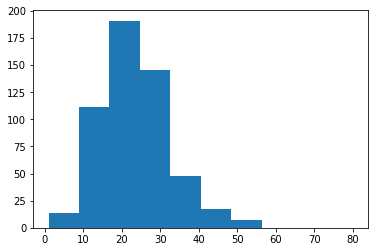

In [97]:
import matplotlib as mlt
plt.hist([len(train_data[1][i]) for i in range(len(train_data[1]))],bins = 10,rwidth=1, range=(1,80))
plt.show()

In [103]:
print(train_data[1][:5])

[[1, 1, 1, 1, 2, 6, 6, 6, 6, 6, 6, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 7], [2, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7], [1, 1, 1, 2, 3, 6, 6, 6, 4, 4, 5, 5, 7], [1, 1, 1, 2, 3, 3, 3, 3, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7], [1, 1, 1, 1, 2, 2, 3, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 7]]


In [31]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


Loading BERT tokenizer...


In [40]:
article,labels_ = train_data[0],train_data[1]

In [106]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_art = []
attention_masks_art = []
labels = []
# For every sentence...
for art in range(len(article)):
    input_ids_sent = []
    attention_masks_sent = []
    for sent in article[art]:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 32,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )
        
        # Add the encoded sentence to the list.    
        input_ids_sent.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks_sent.append(encoded_dict['attention_mask'])


# Convert the lists into tensors.
    input_ids_sent = torch.cat(input_ids_sent, dim=0)
    attention_masks_sent = torch.cat(attention_masks_sent, dim=0)
    labels_sent = torch.tensor(labels_[art])

    input_ids_art.append(input_ids_sent)
    attention_masks_art.append(attention_masks_sent)
    labels.append(labels_sent)

#labels = [label.tolist() for label in labels]

#print('Original: ', article[0])
#print('Token IDs:', input_ids_art[:2],labels[:2])
print(attention_masks_art[:2])
#print(labels[2:4])

[tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [73]:
from torch.utils.data import Dataset
class article_dataset(Dataset):
    def __init__(self,input,target,masks):
        super(article_dataset,self).__init__()
        self.input = input
        self.target = target
        self.masks = masks
    def __getitem__(self,idx):
        return self.input[idx],self.masks[idx],self.target[idx]
    def __len__(self):
        return len(self.input)

In [76]:
dataset = article_dataset(input_ids_art,labels,attention_masks_art)
dataloder = DataLoader(dataset,batch_size=5,shuffle=True)

RuntimeError: stack expects each tensor to be equal size, but got [16, 32] at entry 0 and [49, 32] at entry 1